# Chapter 4: Deep Learning (Part 1) - Data preprocessing

Osman Berk Satir,
Milica Novakovic


Part 1
------------


The objective of this first part is to learn about simple data curation practices. Data curation (for machine learning) consists basically in analyse, label, and separate in classes your input data.  In section two, you used pre-curated and separated data from the INRIA's person data set. Your first task is to create your training/testing sets by hand and analyse how well "balance" they are. 

**Objectives** 
In the following sections, you will use this part to "feed" both, a classic _Swallow_ (not-Deep) classification using handcrafted features and a Deep (kind of Deep) neuronal network. Your task will consist in analyse the accuracy of the aforementioned classification based on the amount of data available; from few hundred of samples to the full data-set.

In this section we will provide the general steps and, as in the previous section, you will be asked to search in the function parameters and syntaxis in users documentation.


## Dataset 

In this last section of the course we will use the the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like _real data_: it's not trivial, and the data is a lot less 'clean' than MNIST.


### Libraries: 

Be sure that you can import all the libraries below, in addition, for next chapter you will make use of the tensor flow library to implement the used neuronal network. Be sure to be able to import it as: 

`` import tensorflow as tf``

following the documentation page 

https://www.tensorflow.org/install/

We will use only CPU's based training. 



In [1]:
import cv2 as cv
import numpy as np
import os
import math
import tarfile
from utils import *
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt
import glob
from six.moves import cPickle as pickle
%matplotlib inline

### Download the data. 

As in section 2, you need to download the data and set the input directory. Be sure to have at about ~1 Gb of free space. If the function is not able to download the data, try on the MNIST site. 



In [2]:

# Download the Data
# The following functions will download the data for you and uncompress it

# WARNING:  These varaibles set the input/output paths for ALL the bellow functions.
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '../data/' # Change me to store data elsewhere


def maybe_download(filename, expected_bytes, force=False):
  """
  Downloads a file if not present, and make sure it's the right size!.
  If there's a file with the same name, the function will not try to 
  download the dataset again!
  """

  dest_filename = os.path.join(data_root, filename)
    
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename, 'This may take a while. Please wait.') 
    filename, _ = urlretrieve(url + filename, dest_filename)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'The file ' + dest_filename + 'already exist but seems corrupted. Delete it or download it from the browser!')
  return dest_filename


def maybe_extract(filename, force=False):
  """
  Uncompress the data set for you
  """
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz

  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s dataset (seems to be) already present.\nSkipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    tar.extractall(data_root)
    tar.close()
    
  data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
  print("All setup.")
  return data_folders


In [3]:
# Downloads ifa needed.
large_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
small_filename  = maybe_download('notMNIST_small.tar.gz', 8458043)


Found and verified ../data/notMNIST_large.tar.gz
Found and verified ../data/notMNIST_small.tar.gz


In [4]:
large_folders = maybe_extract(large_filename)
small_folders = maybe_extract(small_filename)

../data/notMNIST_large dataset (seems to be) already present.
Skipping extraction of ../data/notMNIST_large.tar.gz.
All setup.
../data/notMNIST_small dataset (seems to be) already present.
Skipping extraction of ../data/notMNIST_small.tar.gz.
All setup.


In [5]:
large_folders

['../data/notMNIST_large/A',
 '../data/notMNIST_large/B',
 '../data/notMNIST_large/C',
 '../data/notMNIST_large/D',
 '../data/notMNIST_large/E',
 '../data/notMNIST_large/F',
 '../data/notMNIST_large/G',
 '../data/notMNIST_large/H',
 '../data/notMNIST_large/I',
 '../data/notMNIST_large/J']

---
Problem 1
---------

When working with data, always check your data. 

Create a description of your input data. Describe in a table or list (one for each sample size): 

* Number of classes (characters)
* Number of samples per class
* General information on the image size and number of channels.

Visualize one sample per class bellow for a chosen size (large or small). 

---


The next function find the path of the common folder from list of subdirectories which has common folder. We will use it to find path of folder for large and small dataset once from list large_folders

In [6]:
def get_common_path(path_list):
    path_folder = os.path.commonprefix(path_list)
    return path_folder

Now we will write a function to give us information of number of classes and number of images per each class in form of dicitonary

In [7]:
from PIL import Image
import os.path

def samples_and_classes_num(common_path):
    list_of_dirs = []
    num_of_samples = []
    num_of_channels = []
    img_sizes = []
    dict_of_dirs = {}
    first_traverse = True
    # from the folder common_path we navigate through subfolders and files in them
    for i, value in enumerate(os.walk(common_path)):
        root, dirs, files = value
        # once take store the list of the subfolders
        if (first_traverse):
            list_of_dirs.extend(dirs)
            first_traverse = False
        else:
            dict_of_dirs[list_of_dirs[i-1]] = len(files)
            # how many files is in this subfolder
            num_of_samples.append(len(files))
            filename = os.path.join(root, files[0])
            # to see the size of the image we open it using Pillow
            img = Image.open(filename)
            # if there is 2 dimesions, the image iz grayscale, so we append that there is only one channel
            if len(img.size)==2:
                num_of_channels.append(1)
            else:
                num_of_channels.append(img[2])
            img_sizes.append(img.size)
    # give back all desired data
    return i, num_of_samples, list_of_dirs, dict_of_dirs, img_sizes, num_of_channels

For large_folders we will find the desired data

In [8]:
folder = get_common_path(small_folders)
i, num_of_samples, list_of_dirs, dict_of_dirs, img_sizes, num_of_channels = samples_and_classes_num(folder)
print("Number of classes ",i)
print("Num of samples for each letter ", num_of_samples)
print("List of classes ", list_of_dirs)
print("Dictionary with number of samples for each class ", dict_of_dirs)
print("Image sizes for each class ", img_sizes)
print("Number of channels for each class ", num_of_channels)

Number of classes  10
Num of samples for each letter  [1873, 1873, 1872, 1872, 1873, 1873, 1872, 1873, 1872, 1873]
List of classes  ['C', 'A', 'H', 'G', 'D', 'E', 'J', 'F', 'I', 'B']
Dictionary with number of samples for each class  {'C': 1873, 'A': 1873, 'H': 1872, 'G': 1872, 'D': 1873, 'E': 1873, 'J': 1872, 'F': 1873, 'I': 1872, 'B': 1873}
Image sizes for each class  [(28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28)]
Number of channels for each class  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Now we will put the data in the Dataframe which looks similar as Table

In [9]:
import pandas as pd
def make_dataframe_from_lists(index_list, list_of_list, list_of_names):
    data= dict(zip(list_of_dirs,list_of_list))
    df = pd.DataFrame(data, index = list_of_dirs)
    df.columns = list_of_names
    return df

In [10]:
list_of_list = []
list_of_names = []
list_of_list = [num_of_samples, num_of_channels, img_sizes]
list_of_names = ["samples","channels","image_sizes"]
df = make_dataframe_from_lists(list_of_dirs,list_of_list, list_of_names)
df

,samples,channels,image_sizes
C,1873,1,"(28, 28)"
A,1873,1,"(28, 28)"
H,1872,1,"(28, 28)"
G,1872,1,"(28, 28)"
D,1873,1,"(28, 28)"
E,1873,1,"(28, 28)"
J,1872,1,"(28, 28)"
F,1873,1,"(28, 28)"
I,1872,1,"(28, 28)"
B,1873,1,"(28, 28)"



Now that you have all your images set up we will load the data into a more manageable format. Since depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. 

To do this we will use pickles!

https://docs.python.org/3.2/library/pickle.html

“Pickling” is the process whereby a Python object (it can be anything!) is converted into a byte stream (binary format), and “unpickling” is the inverse operation. We will use pickles to save the FULL set of images for each character in one pickle. The result will be a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. This process is known as "normalizing the data" or "feature scaling, which is very important to ensure convergence in the optimization step, as well to ensure that the feature space is well defined.

https://en.wikipedia.org/wiki/Feature_scaling


Your task: using the skeleton function bellow you need to: 

* 1) Load all the images in FLOAT format for each class (A,..,J), 1 channel only.
* 2) Transform each image intensities such that the range goes from -125,125 (instead of 0, 256)
* 3) Scale the function so the new range goes from -0.5 to 0.5.

A few images might not be readable, we'll just skip them.

In [11]:

""" Image fixed size  """
image_size  = 28     # Pixel width and height. (28x28)
pixel_depth = 255.0  # Number of levels per pixel. (0,255)

""" There's should be enough data at the end"""
min_num_images_train = 45000;
min_num_images_test  = 1800;



def load_letter(folder, min_num_images, verbose = True):
    
#   """" 
#       Base function: 
  
#       Complete this function to read a each iamge of a given character (folder)
#       Transforms and scale the image to have 0 mean and standard deviation of ~0.5.
      
#       Params: 
#           folder: input character folder (e.g. ../data/notMNIST_large/A/)
#           min_num_images: minimum number of images you should have per character.
      
#       returns: 
#           dataset: Vector containing the fully loaded and scaled dataset.
#   """
    image_files = os.listdir(folder)
    
    # Array size (should be preserved)  
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),dtype=np.float32)
    if verbose:
        print(folder)
    num_images = 0

    # List of all the images inside the folder  
    for image in image_files:
        image_file = os.path.join(folder, image)
        filename = image_file
        # If the image is not loadable (there are some corrupted images you can skip them) 
        try:

          # CODE HERE:

          #Load each image and transform them
            image_data = np.array(Image.open(filename)).astype("float64")
            #img_mean, img_std  = np.mean(image_data), np.std(image_data)
            image_data = np.reshape((image_data-pixel_depth/2)/pixel_depth, (image_size, -1))
        #--- End of your code.

          # here I check that you load them correctly and save it in the dataset array.  
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.size))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]

    # If this theshhold is not met, you are doind something wrong (probably)  
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))

    #Check this output! 
    # The mean shoudl be very close to 0 i.e < 1 and the std should be less than 0.5.
    if verbose:
        print('Full dataset tensor:', dataset.shape)
        # Notice we aree callign this a "tensor"

        print('Mean:', np.mean(dataset))
        print('Standard deviation:', np.std(dataset))
    return dataset


In [12]:
folder = "../data/notMNIST_small/A"
min_num_images = 1800
dataset_smallA = load_letter(folder, min_num_images) #Here we can see that mean and standard deviation is as it is expected.

../data/notMNIST_small/A
Could not read: ../data/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file '../data/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - it's ok, skipping.
Full dataset tensor: (1872, 28, 28)
Mean: -0.13262635
Standard deviation: 0.445128


In [13]:
# Look, Morty, I'm a Pickle!        

# This function calls your pre-defined-function load_letter(folder, min_num_images) and creates the pickle!

def Im_a_pickle(data_folders, min_num_images_per_class, force=False):
    
    """ Base function: 
  
      Loads all the images listed in data_folders and creates a .pickle file
      
      Params: 
          data_folders: list of the folders to pickle (i.e. large_folders, small_folders)
          min_num_images: minimum number of images you should have per character.
      
      returns: 
          dataset_names: Vector containing all the pickles names.
  """
    dataset_names = []

    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
    
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Turning myself into a Pickle! %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return dataset_names



If everything was done correctly we can then call the following functiosn without error!

Notice that we are here considereing the "large" data set as our training data set and the small as our test data set.

In [14]:
train_datasets = Im_a_pickle(large_folders, 45000)
test_datasets  = Im_a_pickle(small_folders, 1800)

../data/notMNIST_large/A.pickle already present - Skipping pickling.
../data/notMNIST_large/B.pickle already present - Skipping pickling.
../data/notMNIST_large/C.pickle already present - Skipping pickling.
../data/notMNIST_large/D.pickle already present - Skipping pickling.
../data/notMNIST_large/E.pickle already present - Skipping pickling.
../data/notMNIST_large/F.pickle already present - Skipping pickling.
../data/notMNIST_large/G.pickle already present - Skipping pickling.
../data/notMNIST_large/H.pickle already present - Skipping pickling.
../data/notMNIST_large/I.pickle already present - Skipping pickling.
../data/notMNIST_large/J.pickle already present - Skipping pickling.
../data/notMNIST_small/A.pickle already present - Skipping pickling.
../data/notMNIST_small/B.pickle already present - Skipping pickling.
../data/notMNIST_small/C.pickle already present - Skipping pickling.
../data/notMNIST_small/D.pickle already present - Skipping pickling.
../data/notMNIST_small/E.pickle al

---
## Problem 2

---------

To corroborate that our data is properly saved and scaled, display one example per class letter (A,...,J), from the train dataset **or** the test dataset. 

To do this you will need to use the ``pickle.load(...)``. Check the documentation above for more details. You can use the inhered matplotlib function to show each example. Include a colorbar showing the __values range of the image__.

---

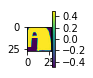

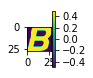

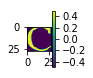

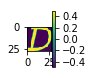

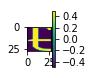

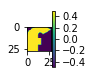

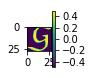

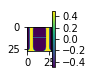

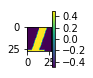

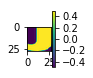

In [15]:
# code here
import random
def sample_pickles_with_plotting(datasets):
    image_list = []
    num_of_images = len(datasets)
    index=1
    plt.show()
    for folder in (datasets):
        letter_sampled = False
        # until we pick on letter that can be accessed iterate and pick random letter to be displayed
        while (not letter_sampled):
            try:
                with open(folder, 'rb') as f:
                    letter = pickle.load(f)
                    # take a random example of letter in folder f
                    ind = random.randint(1, len(letter)-1)
                    image_list.append(letter[ind])
                    f.close()
                    index+=1
                    letter_sampled = True
            except Exception as e:
                # we could not manage to read the this letter, display the message
                letter_sampled = False
                print('Unable to read data from', folder, ':', e)
    # plotting            
    fig = plt.figure()
    num_of_images = len(image_list)
    for index, img in enumerate(image_list):
        plt.subplot(1,num_of_images,index+1)
        plt.imshow(img)
        plt.colorbar(fraction=0.1, pad=0.04)
        plt.show()
    return image_list
image_list = sample_pickles_with_plotting(test_datasets)


Finally if everything is correct, the above function should contain the full length of each character sample.  The labels will be stored into a separate array of *integers 0 through 9*.

Corroborate that the train_sets are in the order of ~52,000 images, and the train_set in the order of 1,870 images. 

In [16]:
def data_sets_sizes(data_set):
    
    number_files = []
    """ Base function: 
  
      Loads all the images listed in data_set and return it' s size
      
      Params: 
          data_folders: lsit of the folders to pickle (i.e. large_folders, small_folders)
          min_num_images: minimum number of images you should have per character.
      
      returns: 
          dataset_names: Vector containing all the pickles names.
  """

    #Code here 
    for folder in data_set:
        try:
            with open(folder, 'rb') as f:
                letter = pickle.load(f)
                number_files.append(len(letter))
        except Exception as e:
            print('Can not open or read from', folder, ':', e)
            
    print(number_files)
    
    return number_files
data_sets_sizes(train_datasets)
data_sets_sizes(test_datasets)

[52909, 52911, 52912, 52911, 52912, 52912, 52912, 52912, 52912, 52911]
[1872, 1873, 1873, 1873, 1873, 1872, 1872, 1872, 1872, 1872]


[1872, 1873, 1873, 1873, 1873, 1872, 1872, 1872, 1872, 1872]

---
## Problem 3

---------
Creating sub-sampled datasets.
In order to evaluate the performance of our classifiers, we need to create subsets of our data properly randomized; this means that we shouldn't choose always the first set of images to compare since we will introduce a bias because of the sampled order. A very nice post on this topic can be found below in case you wonder if it's worth the trouble.

https://machinelearningmastery.com/randomness-in-machine-learning/


As problem 3 you are asked to write a function: sample_training_data(...) which should create a training dataset of a given size, containing the same number of samples for each label (-1 or +1 samples) randomly selected from the train-dataset; as well as the labels of the training set coded as integers from 0 (A) to 9 (J).
Is worth mentioning that is common practice in machine learning to set aside a third data set known as the validation dataset. Which is used to prevent overfitting and other training problems. We will not make use of such dataset, however, is worth to check why is used; one nice and short explanation can be found here (it also contains nice code hints relevant to the exercise ;) )

https://machinelearningmastery.com/difference-test-validation-datasets/

---

In [17]:
#Code here.
def sample_training_data(pickle_files, train_size):

    """ Base function: 
  
      Given a train size returns a ndarray containing a total of 
      <train_size/number_of_clases> samples for each character.
      
      example for train_size = 100, should contain 100/10 = 10 samples of each character. 
      
      The samples should be chose randomly.
      
      Params: 
          pickle_files: list of the pickle files (training set)
          train_size: total length of the new training set
      
      returns: 
          train_dataset: ndarray containing all the trainign images (properly normalized)
          train_labels : the labels of each selected image. 
  """
    train_dataset = []
    train_labels = []
    num_of_classes = 10
    num_of_each_class_samples = int(train_size/num_of_classes)
    for label, folder in enumerate(pickle_files):
        try:
            with open(folder, 'rb') as f:
                letter = pickle.load(f)
                # randomly uniformly sample the letters, by sampling indices from appropriate interval
                class_samples = random.sample(list(letter),num_of_each_class_samples)
                train_dataset.extend(class_samples)
                # make a labels for each picked example
                labels = [label]*num_of_each_class_samples
                train_labels.extend(labels)
                f.close()
        except Exception as e:
            # print the message
            print('Can not read data from', folder, ':', e)
    train_dataset = np.array(train_dataset)
    train_labels = np.array(train_labels)
    return train_dataset, train_labels
  

# EXAMPLE OF USE
train_size = 200000
valid_size = 10000
test_size = 10000

train_dataset, train_labels = sample_training_data(train_datasets, train_size)
val_dataset, val_labels = sample_training_data(train_datasets, valid_size)
test_dataset, test_labels = sample_training_data(test_datasets, test_size)

# Just for easier debugging
print('Training size: ', train_dataset.shape, '\nLabel vector size:',train_labels.shape)
print('Validation size: ', val_dataset.shape, '\nLabel vector size:',val_labels.shape)
print('Test size: ', test_dataset.shape, '\nLabel vector size:',test_labels.shape)

Training size:  (200000, 28, 28) 
Label vector size: (200000,)
Validation size:  (10000, 28, 28) 
Label vector size: (10000,)
Test size:  (10000, 28, 28) 
Label vector size: (10000,)


Finally, you need to randomize the vector so it doesn't follow any specific order: like first all the A characters and then the 'B' characters, and so on 

```(A, A, ..., A , B, B, ..., B, C, C, ...,C,... )```.


In [18]:
# Define a function to randomize THE ORDER of a given dataset.
# Be sure that the dataset and the labels are shuffled in the same order so they MATCH.

def randomize(dataset, labels):
    #code here
    # get the permutation of indices and apply it on dataset and labels
    shuffled_indices = np.random.permutation(dataset.shape[0])
    shuffled_dataset = dataset[shuffled_indices,:,:]
    shuffled_labels = labels[shuffled_indices]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
val_dataset, val_labels   = randomize(val_dataset, val_labels)
test_dataset, test_labels   = randomize(test_dataset, test_labels)

In [19]:
train_labels[:10] #We can see that the data is randomized.

array([7, 4, 2, 2, 4, 7, 3, 7, 5, 4])

---
Problem 4
---------

Show us that your method works and both datasets are coherent with the labels. You can display the shuffled order and show the first images in both datasets. They should match the labels.

---

Train


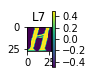

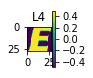

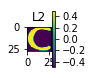

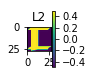

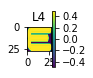

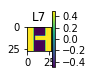

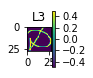

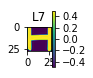

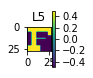

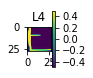

Valid


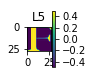

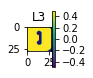

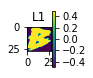

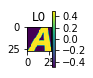

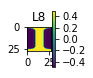

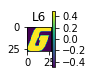

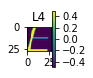

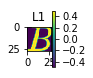

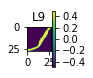

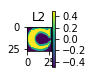

Test


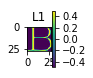

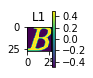

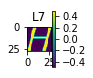

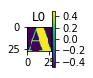

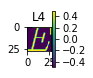

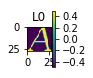

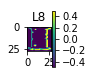

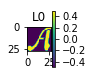

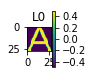

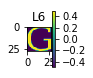

In [20]:
num_of_images = 10
fig = plt.figure()
def display_images_from_dataset(dataset, labels, num_of_images = 10):
    for i in range(num_of_images):
        plt.subplot(1,num_of_images,i+1)
        plt.title("L"+str(labels[i]))
        plt.imshow(dataset[i])
        plt.colorbar(fraction=0.1, pad=0.04)(
        plt.show()

num_of_images = 10
print("Train")
display_images_from_dataset(train_dataset, train_labels, num_of_images)
print("Valid")
display_images_from_dataset(val_dataset, val_labels, num_of_images)
print("Test")
display_images_from_dataset(test_dataset, test_labels, num_of_images)
##Here it is possible to say that the images are scaled from -0.5 to 0.5, their size is 28x28 and the data is coherent
#with the labels(labels are at the top of the images.)

---
Problem 5
---------

By default, this dataset might contain a lot of overlapping samples, including training data that are also contained in the test set. The overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap but are actually ok if you expect to see training samples recur when you use it.

Measure how much overlap there is between training, validation and test samples. 

- Give the number of overlapping samples in the test set for the full dataset.
- What about near duplicates between datasets? (images that are almost identical), provide a __estimation__ based in any metric or function to evaluate similitude with a given threshold.  
- Modify your ``sample_training_data``function and provide a curated train and test dataset removing the very similar samples from one of them. 
---

**Here, the estimation of overlapping samples is that if we rescale the images to 8x8 and hash them, the images with the same hashes would be either totally the same or really similar. First, we give the overlap for full dataset (500000< train and 18000< test images) and the overlap without rescaling(for exactly the same images).Next, we do the same for the sampled dataset(200000 train and 10000 test images). Then after changing our sample_training_data function with sample_training_data_modified, it is possible to see that there is no more overlap. The modification we did is we get four inputs, pickle files and sizes for both test and train dataset. Then after creating the train set, we get the hashes of reshaped (8x8) train dataset, then when creating the test dataset, we get a random image, scale it to 8x8, hashing it and if that hash is in the hashes of train dataset, we skip that image and get a new one.**

In [21]:
train_sizes=data_sets_sizes(train_datasets)
test_sizes=data_sets_sizes(test_datasets)

[52909, 52911, 52912, 52911, 52912, 52912, 52912, 52912, 52912, 52911]
[1872, 1873, 1873, 1873, 1873, 1872, 1872, 1872, 1872, 1872]


In [22]:
def all_data(pickle_files, train_size):
    #This function gets all the readable data for checking the overlapping samples between large and small dataset.
   
    train_dataset = []
    train_labels = []
    num_of_classes = 10
    num_of_each_class_samples = train_size
    i=0
    for label, folder in enumerate(pickle_files):
        try:
            with open(folder, 'rb') as f:##Reading all the pickles in the folder.
                letter = pickle.load(f)
                class_samples = random.sample(list(letter),train_size[i])
                train_dataset.extend(class_samples)#Getting the data.
                labels = [label]*train_size[i]
                i=i+1
                train_labels.extend(labels) #Getting the labels
                f.close()
        except Exception as e:
            print('Can not read data from', folder, ':', e)
    train_dataset = np.array(train_dataset)
    train_labels = np.array(train_labels)
    return train_dataset, train_labels
  

In [23]:
all_train,all_train_label=all_data(train_datasets,train_sizes)
all_test,all_test_label=all_data(test_datasets,test_sizes)

In [24]:
def overlap_counter(train_dataset,test_dataset):
    train_dataset_flattened=np.reshape(train_dataset,(train_dataset.shape[0],28*28))
    test_dataset_flattened=np.reshape(test_dataset,(test_dataset.shape[0],28*28))
    train_dataset_flattened_resized=np.zeros((train_dataset.shape[0],64))
    test_dataset_flattened_resized=np.zeros((test_dataset.shape[0],64))

    for i in range (train_dataset.shape[0]):
        train_dataset_flattened_resized[i]=np.reshape(cv.resize(train_dataset[i],(8,8)),(1,64))#Reshaping and resizing the
        #train dataset.
        
    for i in range (test_dataset.shape[0]):
        test_dataset_flattened_resized[i]=np.reshape(cv.resize(test_dataset[i],(8,8)),(1,64))#Reshaping and resizing the
        #test dataset.
    print("Resizing and reshaping done!")
    
    hash_of_train=[]
    for i in range (train_dataset.shape[0]):
        a=hash(tuple(train_dataset_flattened_resized[i]))#Getting list of hashes for train.
        hash_of_train.append(a)
    print("Train hashing done!")
    hash_of_test=[]
    for i in range (test_dataset.shape[0]):
        a=hash(tuple(test_dataset_flattened_resized[i]))#Getting list of hashes for test.
        hash_of_test.append(a)
    print("Test hashing done!")

    mask=np.isin(hash_of_test,hash_of_train)
    overlap_count=len(np.where(mask==True)[0])#Checking how many elements of test hash list in the train hash list.
    print("Number of overlapping samples is: ",overlap_count)
    return overlap_count



In [25]:
def overlap_counter_exactly(train_dataset,test_dataset):
    train_dataset_flattened=np.reshape(train_dataset,(train_dataset.shape[0],28*28))
    test_dataset_flattened=np.reshape(test_dataset,(test_dataset.shape[0],28*28))
  

    for i in range (train_dataset.shape[0]):
        train_dataset_flattened[i]=train_dataset[i].flatten()#Flattening resizing the
        #train dataset.
        
    for i in range (test_dataset.shape[0]):
        test_dataset_flattened[i]=test_dataset[i].flatten()#Flattening the
        #test dataset.
    print("Resizing done!")
    
    hash_of_train=[]
    for i in range (train_dataset.shape[0]):
        a=hash(tuple(train_dataset_flattened[i]))#Getting list of hashes for train.
        hash_of_train.append(a)
    print("Train hashing done!")
    hash_of_test=[]
    for i in range (test_dataset.shape[0]):
        a=hash(tuple(test_dataset_flattened[i]))#Getting list of hashes for test.
        hash_of_test.append(a)
    print("Test hashing done!")

    mask=np.isin(hash_of_test,hash_of_train)
    overlap_count=len(np.where(mask==True)[0])#Checking how many elements of test hash list in the train hash list.
    print("Number of overlapping samples is: ",overlap_count)
    return overlap_count


In [26]:
overlap_counter(train_dataset,test_dataset)##Overlap of sampled dataset (similar and exactly the same images)
overlap_counter_exactly(train_dataset,test_dataset)##Overlap of sampled dataset (exactly the same images)
overlap_counter(all_train,all_test)##Overlap of whole dataset (similar and exactly the same images)
overlap_counter_exactly(all_train,all_test)##Overlap of whole dataset (exactly the same images)

#Whole dataset is the one with containing all images in large and small folders

#Sampled dataset is the one that we sampled 200000 training images from large folder and sampled 10000 test images from
#the small one.

Resizing and reshaping done!
Train hashing done!
Test hashing done!
Number of overlapping samples is:  1334
Resizing done!
Train hashing done!
Test hashing done!
Number of overlapping samples is:  1319
Resizing and reshaping done!
Train hashing done!
Test hashing done!
Number of overlapping samples is:  5021
Resizing done!
Train hashing done!
Test hashing done!
Number of overlapping samples is:  4977


4977

In [27]:
#Code here.
def sample_training_data_modified(pickle_files1, train_size ,pickle_files2, test_size):
    #This function takes train data folders, train set size, test data folders and test set size as inputs and returns
    #train set, train labels, test set and test labels. The modification from sample_training_data is, when we create
    #the test dataset, while we are adding test samples, we check its hash, whether it exists in train hash list or not. If
    #yes, we skip that image and select another one randomly and it continues until we get enough number of non-overlapping
    #samples inbetween train and test datasets.
    train_dataset = []
    train_labels = []
    test_dataset = []
    test_labels = []
    num_of_classes = 10
    num_of_each_class_samples = int(train_size/num_of_classes)
    for label, folder in enumerate(pickle_files1):
        try:
            with open(folder, 'rb') as f: ##Sampling the train dataset.
                letter = pickle.load(f)
                class_samples = random.sample(list(letter),num_of_each_class_samples)#Randomly selecting the images.
                train_dataset.extend(class_samples)
                labels = [label]*num_of_each_class_samples#Getting the labels.
                train_labels.extend(labels)
                f.close()
        except Exception as e:
            print('Can not read data from', folder, ':', e)
    train_dataset = np.array(train_dataset)
    train_labels = np.array(train_labels)
    hash_of_train=[]
    
    #train_dataset_flattened=np.reshape(train_dataset,(train_size,28*28))
    train_dataset_flattened_resized=np.zeros((train_size,64))

    for i in range (train_dataset.shape[0]):
        #print(i)
        train_dataset_flattened_resized[i]=np.reshape(cv.resize(train_dataset[i],(8,8)),(1,64)) #Reshaping and resizing the train set.
        
    
    for i in range (train_dataset.shape[0]):
        a=hash(tuple(train_dataset_flattened_resized[i]))
        hash_of_train.append(a) #Obtaining hash table of the train set.
    
    
    num_of_each_class_samples2 = int(test_size/num_of_classes)

    for label, folder in enumerate(pickle_files2):
        #print(label,folder)
        #start = time.clock()

        try:
            with open(folder, 'rb') as f:
                letter = pickle.load(f)
                count=0
                while (count<num_of_each_class_samples2): #Making sure that we get same number of sample from each class.
                    class_samples = random.sample(list(letter),1)
                    class_samples=np.array(class_samples)
                    if np.isin(hash(tuple(np.reshape(cv.resize(class_samples[0,:,:],(8,8)),(1,64))[0])),hash_of_train)==False:
                        #Here we check the hash of each test image, if it exists in the hash list of train, we dont add that image.
                        test_dataset.extend(class_samples)
                        count=count+1
                        
                labels = [label]*num_of_each_class_samples2
                test_labels.extend(labels)
                f.close()
        except Exception as e:
            print('Can not read data from', folder, ':', e)

    test_dataset = np.array(test_dataset)
    test_labels = np.array(test_labels)
    
    
    
    
    
    return train_dataset, train_labels, test_dataset, test_labels
  

# EXAMPLE OF USE
train_size = 200000
valid_size = 10000
test_size = 10000

train_dataset, train_labels , test_dataset, test_labels= sample_training_data_modified(train_datasets, train_size, test_datasets, test_size)


print('Training size: ', train_dataset.shape, '\nLabel vector size:',train_labels.shape)
#print('Test size: ', val_dataset.shape, '\nLabel vector size:',val_labels.shape)
print('Test size: ', test_dataset.shape, '\nLabel vector size:',test_labels.shape)

Training size:  (200000, 28, 28) 
Label vector size: (200000,)
Test size:  (10000, 28, 28) 
Label vector size: (10000,)


In [28]:
train_dataset, train_labels = randomize(train_dataset, train_labels)#Randomizing the new datasets
test_dataset, test_labels   = randomize(test_dataset, test_labels)

In [29]:
overlap_counter(train_dataset,test_dataset)##Overlap of sampled dataset (similar and exactly the same images)
overlap_counter_exactly(train_dataset,test_dataset)##Overlap of sampled dataset (exactly the same images)


Resizing and reshaping done!
Train hashing done!
Test hashing done!
Number of overlapping samples is:  0
Resizing done!
Train hashing done!
Test hashing done!
Number of overlapping samples is:  0


0

---
Problem 6
---------

Let's get an idea of what a basic classifier can give you on this data. 

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. 

Hint: you can use the ```LogisticRegression``` or ```LogisticRegressionCv``` model from sklearn.linear_model.

Provide a score for the prediction over the full test data set. You can use any metric from the previous chapters or an implemented one like the ```cross_val_score``` form sklearn which is more accurate.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

A good choice of parameters (and regularization method) can give you results up to the 89%



```
#Samples: 50 ---> Score: 0.471428571429
#Samples: 100 ---> Score: 0.605865717935
#Samples: 1000 ---> Score: 0.760772183027
#Samples: 5000 ---> Score: 0.812826972435 
```



---

In [30]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import cross_val_score

def train_and_validate(num_examples):
    model=LogisticRegressionCV()
    train_set,label,_,_=sample_training_data_modified(train_datasets, num_examples ,[], 0) #We create a dataset with equal nr of images from each class.
    score=cross_val_score(model,np.reshape(train_set,(num_examples,28*28)), label)#Crossvalidate the dataset with k=3.
    score=np.mean(score)#Taking the mean of the 3 scores from 3-fold cross validation.
    return score

/home/obsatir/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
training_sizes = [50, 100, 1000, 5000]

print("Cross Validation Score\n")
for size in training_sizes:
    score = train_and_validate(size)
    print("Samples:", size,"---> Score:", score)
    
    
#Samples: 50 ---> Score: 0.471428571429
#Samples: 100 ---> Score: 0.605865717935
#Samples: 1000 ---> Score: 0.760772183027
#Samples: 5000 ---> Score: 0.812826972435


Cross Validation Score

Samples: 50 ---> Score: 0.5166666666666666
Samples: 100 ---> Score: 0.6694444444444444
Samples: 1000 ---> Score: 0.7759655377302437
Samples: 5000 ---> Score: 0.8015895919005364


**As it is expected from the given scores, the cross validation score increases when we increase our number of samples.**

**In the cell below, we pickle our data set in order to use in the second part. It consists 200000 train images 10000 test images and 10000 validation images. (Note that with this data set, we have 0 overlapping samples between train and test images.)**


In [32]:
pickle_file = '../data/notMNIST.pickle'
f = open(pickle_file, 'wb')
dataset_dict = {'train_dataset': train_dataset, 'train_labels': train_labels, 'valid_dataset': val_dataset, 'valid_labels': val_labels, 'test_dataset': test_dataset, 'test_labels': test_labels, }
pickle.dump(dataset_dict, f, pickle.HIGHEST_PROTOCOL)
f.close()


**To sum up, in this part we preprocess by getting our data folders (large and small), rescaling, clearing and randomizing the order of our data. As the result, the pixel values are between -0.5 and 0.5, the labels are set to 0 to 9 and there are no overlapping samples (either same or very similar) in train and test datasets. At the end of preprocessing, we save our data(200000 train, 10000 validation and 10000 test images without overlapping samples) into a pickle in order to use it in MLP and SVM comparison in the second part. **